In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 
import re

# Load Data

In [6]:
survey_df = pd.read_csv("survey_full.csv")
transcript_df = pd.read_csv("all_transcripts.csv")

In [7]:
# Add columns for affect and arousal change
survey_df["affect_change"] = survey_df["end_affect"] - survey_df["begin_affect"]
survey_df["affect_change_is_positive"] = np.where(survey_df["affect_change"] > 0, 1, 0)
survey_df["affect_change_sign"] = np.where(survey_df["affect_change"] > 0, 1, np.where(survey_df["affect_change"] < 0, -1, 0))
survey_df["arousal_change"] = survey_df["end_arousal"] - survey_df["begin_arousal"]
survey_df["arousal_change_is_positive"] = np.where(survey_df["arousal_change"] > 0, 1, 0)
survey_df["arousal_change_sign"] = np.where(survey_df["arousal_change"] > 0, 1, np.where(survey_df["arousal_change"] < 0, -1, 0))

In [8]:
# Group into "good" and "bad" conversations: top 25% and bottom 25% of conversationalists
# Doesn't matter if one is bad and one is good: we only care about what person thinks about chatbot, not about what chatbot thinks of person
conversationalist_upper_quant = survey_df.conversationalist.quantile(0.75)
conversationalist_bottom_quant = survey_df.conversationalist.quantile(0.25)
top_quant_conversations = survey_df[survey_df["conversationalist"]>conversationalist_upper_quant]
bottom_quant_conversations = survey_df[survey_df["conversationalist"]<conversationalist_bottom_quant]

In [9]:
survey_df.corr()["backchannel_recieved"]

Unnamed: 0                    0.002584
survey_duration_in_seconds    0.049624
time_zone                     0.028009
pre_affect                   -0.002940
pre_arousal                   0.000762
                                ...   
affect_change_is_positive     0.051565
affect_change_sign            0.049904
arousal_change                0.054040
arousal_change_is_positive    0.044078
arousal_change_sign           0.049145
Name: backchannel_recieved, Length: 215, dtype: float64

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

In [25]:
# For reference, visualize sentiment distribution of a random conversation
random_conv_id = transcript_df.conversation[0]
random_conversation = (transcript_df[transcript_df["conversation"] == random_conv_id]).copy()
random_conversation["sentiment_score"] = random_conversation["utterance"].apply(lambda x: sia.polarity_scores(x)["compound"])
plt.hist(random_conversation["sentiment_score"])

In [40]:
# Sentiment score for each utterance
transcript_df["sentiment_score"] = transcript_df["utterance"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [42]:
# Probabilities of each sentiment
transcript_df["sentiment_positive"] = transcript_df["utterance"].apply(lambda x: sia.polarity_scores(x)["pos"])
transcript_df["sentiment_neutral"] = transcript_df["utterance"].apply(lambda x: sia.polarity_scores(x)["neu"])
transcript_df["sentiment_negative"] = transcript_df["utterance"].apply(lambda x: sia.polarity_scores(x)["neg"])

In [43]:
transcript_df.to_csv("all_transcripts_with_sentiment.csv")

In [59]:
good_conversations = transcript_df[transcript_df["conversation"].isin(top_quant_conversations["conversation"])]
bad_conversations = transcript_df[transcript_df["conversation"].isin(bottom_quant_conversations["conversation"])]


# Sentiment Analysis

### Message Sentiment Score

Text(0, 0.5, 'Frequency')

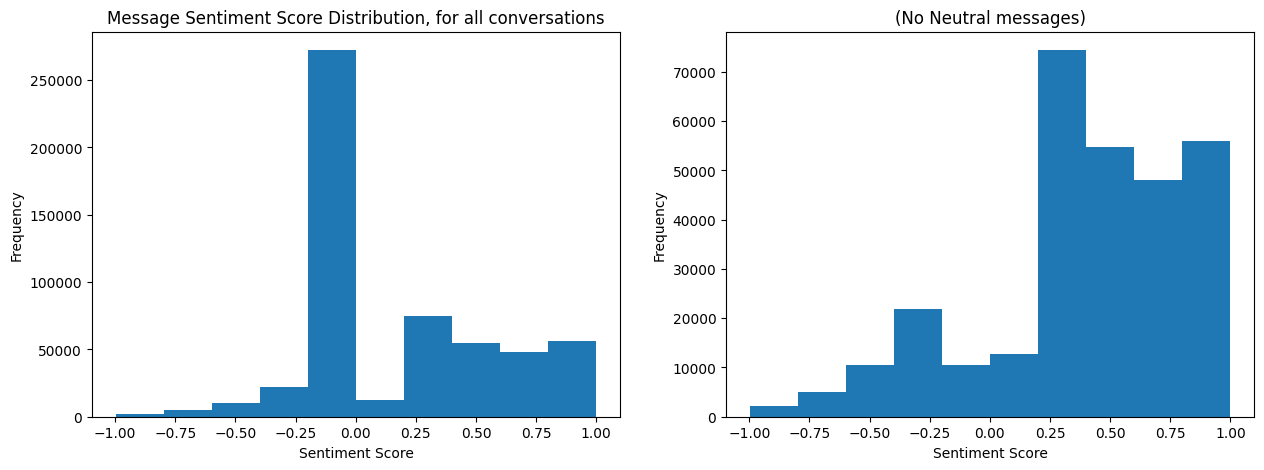

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(transcript_df["sentiment_score"])
ax[0].set_title("Message Sentiment Score Distribution, for all conversations")
ax[0].set_xlabel("Sentiment Score")
ax[0].set_ylabel("Frequency")
ax[1].hist(transcript_df[transcript_df["sentiment_score"] != 0]["sentiment_score"])
ax[1].set_title("(No Neutral messages)")
ax[1].set_xlabel("Sentiment Score")
ax[1].set_ylabel("Frequency")

Text(0, 0.5, 'Message Count')

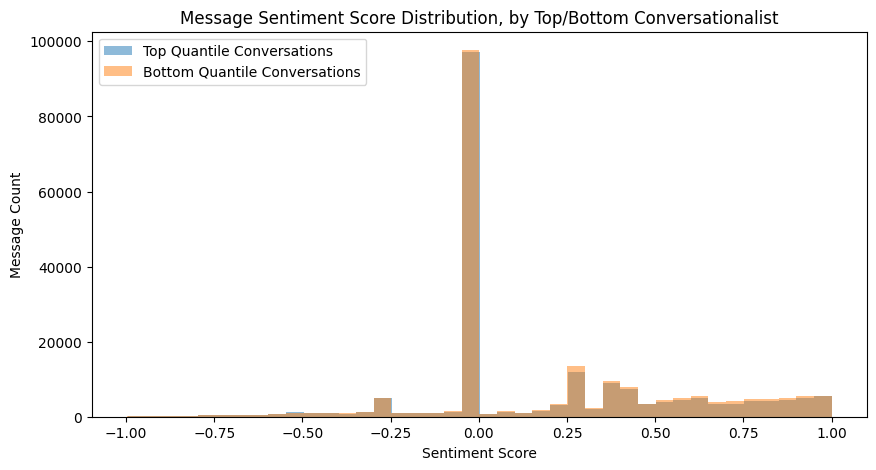

In [67]:
# Sentiment score distribution for top and bottom conversationalists (is around the same)
plt.figure(figsize=(10, 5))
plt.hist(good_conversations['sentiment_score'], alpha=0.5, label="Top Quantile Conversations", bins=40)
plt.hist(bad_conversations["sentiment_score"], alpha=0.5, label="Bottom Quantile Conversations", bins=40)
plt.legend(loc='upper left')
plt.title("Message Sentiment Score Distribution, by Top/Bottom Conversationalist")
plt.xlabel("Sentiment Score")
plt.ylabel("Message Count")

In [79]:
import scipy.stats as stats
data1 = good_conversations['sentiment_score']
data2 = bad_conversations['sentiment_score']
print(data1.mean(), data2.mean())
print(np.var(data1), np.var(data2)) # similar variance
stats.ttest_ind(data1, data2, equal_var=True) 

0.19958618605093414 0.21255440250073857
0.13196151546781956 0.13249939621886003


Ttest_indResult(statistic=-11.409521918076646, pvalue=3.787383569208282e-30)

### Conversation Mean Sentiment Score

In [80]:
# Mean sentiment for conversation
all_conversation_mean_sentiment = transcript_df.groupby("conversation").mean()["sentiment_score"]
good_conversation_mean_sentiment = good_conversations.groupby("conversation").mean()["sentiment_score"]
bad_conversation_mean_sentiment = bad_conversations.groupby("conversation").mean()["sentiment_score"]

(array([ 17.,  91., 293., 364., 389., 285., 141.,  61.,  13.,   2.]),
 array([0.04083828, 0.08479653, 0.12875478, 0.17271303, 0.21667128,
        0.26062953, 0.30458778, 0.34854603, 0.39250428, 0.43646253,
        0.48042078]),
 <BarContainer object of 10 artists>)

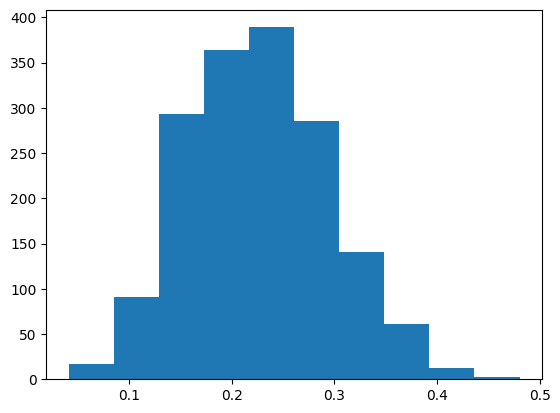

In [55]:
# All conversations are overall positive
plt.hist(transcript_df.groupby("conversation").mean()["sentiment_score"])

In [88]:
bottom_quant_conversations.shape, top_quant_conversations.shape

((775, 233), (626, 233))

Text(0, 0.5, 'Conversation Count')

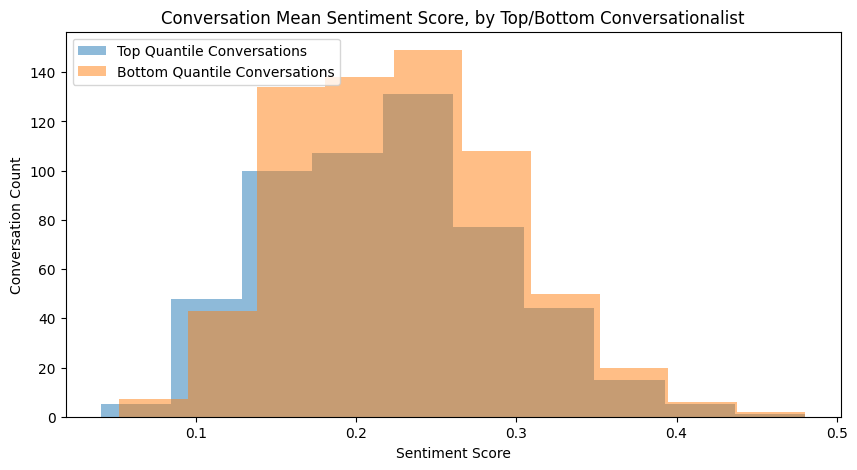

In [84]:
# Sentiment score distribution for top and bottom conversationalists (is around the same)
plt.figure(figsize=(10, 5))
plt.hist(good_conversation_mean_sentiment, alpha=0.5, label="Top Quantile Conversations", bins=10)
plt.hist(bad_conversation_mean_sentiment, alpha=0.5, label="Bottom Quantile Conversations", bins=10)
plt.legend(loc='upper left')
plt.title("Conversation Mean Sentiment Score, by Top/Bottom Conversationalist")
plt.xlabel("Sentiment Score")
plt.ylabel("Conversation Count")

In [85]:
print(good_conversation_mean_sentiment.mean(), bad_conversation_mean_sentiment.mean())
print(np.var(good_conversation_mean_sentiment), np.var(bad_conversation_mean_sentiment)) # similar variance
stats.ttest_ind(good_conversation_mean_sentiment, bad_conversation_mean_sentiment, equal_var=True) 

0.21951884754838677 0.22770027341951807
0.004843286614044429 0.004646139000411971


Ttest_indResult(statistic=-2.037990625972319, pvalue=0.041772010225339634)

### Frequent Words

In [91]:
good_conv_w_backchannels = good_conversations[good_conversations["backchannel"].notnull()]
bad_conv_w_backchannels = bad_conversations[bad_conversations["backchannel"].notnull()]

In [117]:
all_words = {}
for words in good_conv_w_backchannels["backchannel"].values:
    split_words = words.split(".")
    for word in split_words:
        if word.strip():
            word = word.strip().lower()
            if word in all_words:
                all_words[word] += 1
            else:
                all_words[word] = 1

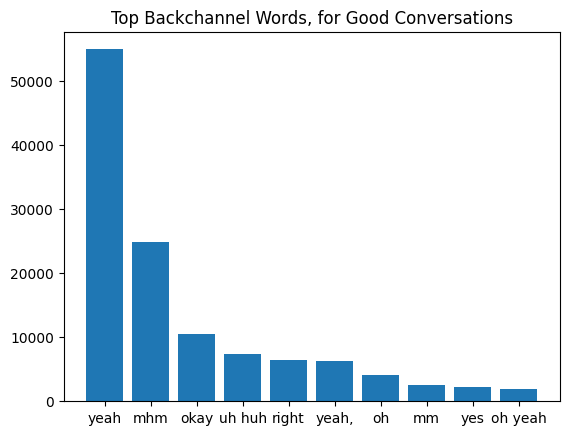

In [139]:
top_all_words = [k for k, v in sorted(all_words.items(), reverse=True, key=lambda item: item[1])]
top_all_words = top_all_words[:10]
plt.bar(range(len(top_all_words)), [all_words[key] for key in top_all_words], align='center', )
plt.xticks(range(len(top_all_words)), top_all_words)
plt.title("Top Backchannel Words, for Good Conversations")
plt.show()


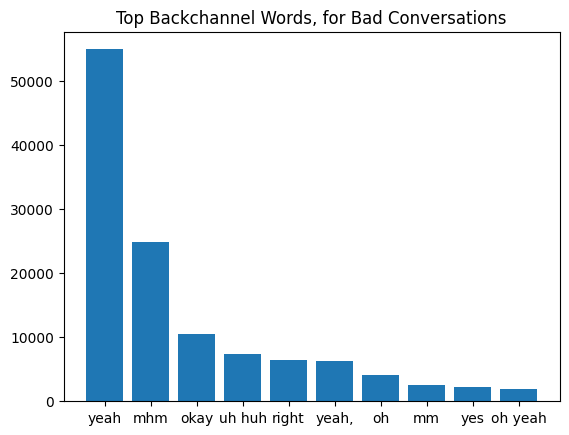

In [138]:
all_words = {}
for words in bad_conv_w_backchannels["backchannel"].values:
    split_words = words.split(".")
    for word in split_words:
        if word.strip():
            word = word.strip().lower()
            if word in all_words:
                all_words[word] += 1
            else:
                all_words[word] = 1
top_all_words = [k for k, v in sorted(all_words.items(), reverse=True, key=lambda item: item[1])]
top_all_words = top_all_words[:10]
plt.bar(range(len(top_all_words)), [all_words[key] for key in top_all_words], align='center', )
plt.xticks(range(len(top_all_words)), top_all_words)
plt.title("Top Backchannel Words, for Bad Conversations")
plt.show()

In [ ]:
# Are sentiments mirrored?

(array([ 2260.,  4958., 10551., 21899., 10436., 12703., 74452., 54694.,
        48054., 55918.]),
 array([-0.997 , -0.7973, -0.5976, -0.3979, -0.1982,  0.0015,  0.2012,
         0.4009,  0.6006,  0.8003,  1.    ]),
 <BarContainer object of 10 artists>)

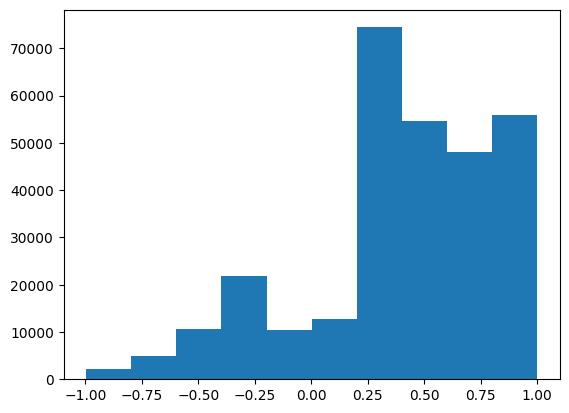

In [45]:
plt.hist(transcript_df[transcript_df["sentiment_score"] != 0]["sentiment_score"])

In [ ]:
pd.set_option('display.max_colwidth', 50)
(random_conversation[random_conversation["sentiment_score"] < 0]).to_csv("negative_sentiment.csv")